
# BANK LOAN DEFAULT RISK ANALYSIS
## SQL Server Express → Python


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### SQL Server connection

In [2]:
from sqlalchemy import create_engine


In [ ]:
engine = create_engine('mssql+pyodbc://ROHIT\SQLEXPRESS/BankLoanRisk?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes')

print("✅ Connected to SQL Server Express - BankLoanRisk database")
print("="*80)

✅ Connected to SQL Server Express - BankLoanRisk database


### 1. LOAD DATA FROM YOUR CLEANED TABLES & VIEWS

In [4]:
# Main analysis dataset
df = pd.read_sql("""
    SELECT * 
    FROM dw.vw_loan_performance_detail 
    WHERE loan_amount IS NOT NULL
""", engine)

In [5]:
print(f"📊 Loaded {len(df):,} loan records")
print(f"   Default rate: {df['default_flag'].mean():.1%}")
print(df['loan_status'].value_counts())
print("\nDataset shape:", df.shape)
print("\nKey columns:")
print(df.select_dtypes(include=['int64','float64']).columns.tolist())

📊 Loaded 97,940 loan records
   Default rate: 10.0%
loan_status
Current    88135
Default     9805
Name: count, dtype: int64

Dataset shape: (97940, 32)

Key columns:
['loan_id', 'borrower_id', 'origination_year', 'origination_quarter', 'loan_amount', 'interest_rate', 'monthly_payment', 'is_joint_application', 'default_flag', 'annual_income', 'dti_ratio', 'length_credit_history', 'num_total_credit_lines', 'num_open_credit_lines', 'num_open_credit_lines_1_year', 'revolving_balance', 'revolving_utilization_rate', 'num_derogatory_rec', 'num_delinquency_2_years', 'num_chargeoff_1_year', 'num_inquiries_6_mon', 'risk_history_flag']


In [6]:
# Quick data quality check
print("🔍 DATA QUALITY SUMMARY")
print("="*50)
print(f"Null loan_amount: {df['loan_amount'].isna().sum()}")
print(f"Null interest_rate: {df['interest_rate'].isna().sum()}")
print(f"Date range: {df['origination_date'].min()} to {df['origination_date'].max()}")

# Portfolio overview
portfolio_stats = df.agg({
    'loan_amount': ['count', 'sum', 'mean', 'median'],
    'interest_rate': ['mean', 'std']
}).round(2)
print("\n📈 PORTFOLIO STATS")
print(portfolio_stats)


🔍 DATA QUALITY SUMMARY
Null loan_amount: 0
Null interest_rate: 0
Date range: 2014-05-13 to 2016-06-30

📈 PORTFOLIO STATS
         loan_amount  interest_rate
count   9.794000e+04            NaN
sum     2.023022e+09            NaN
mean    2.065573e+04          10.98
median  2.059700e+04            NaN
std              NaN           3.90


### 2. EXPLORATORY DATA ANALYSIS (EDA)

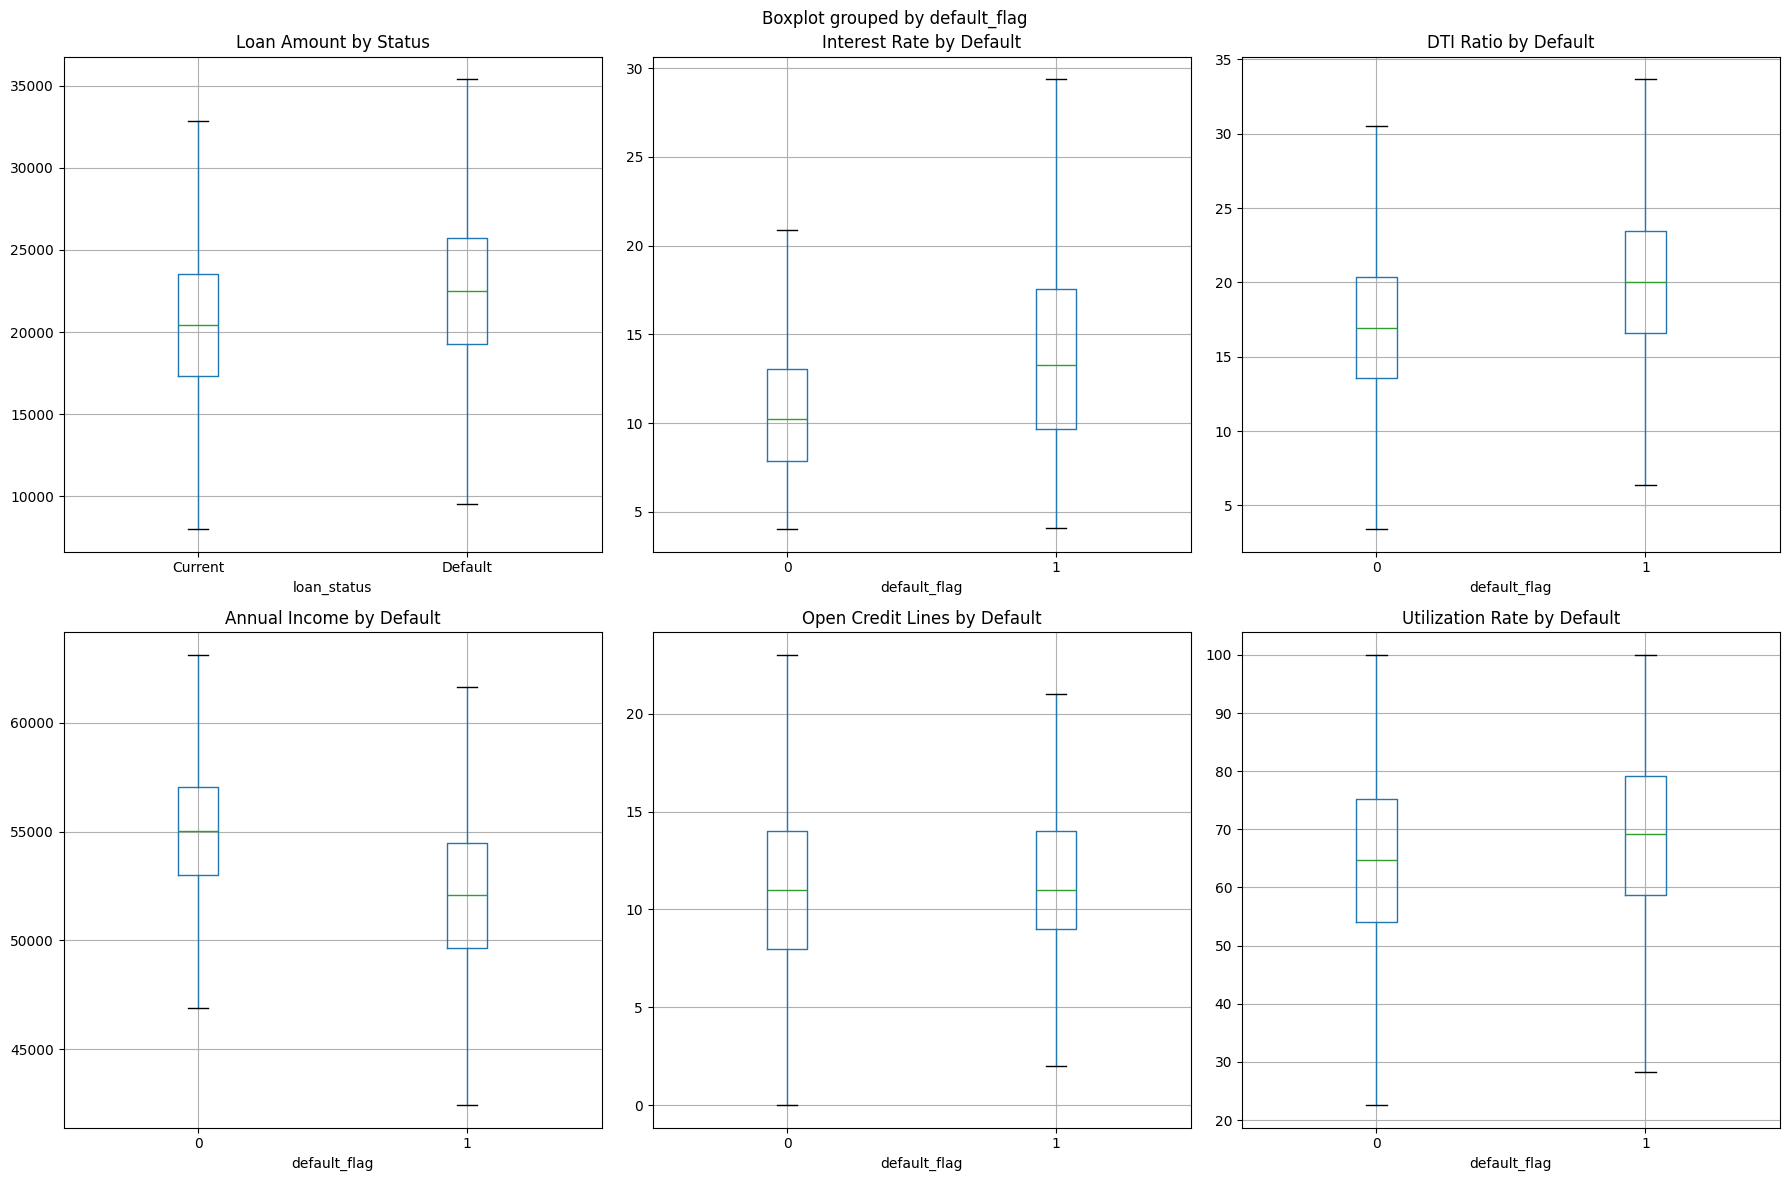

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Loan Portfolio EDA', fontsize=16, fontweight='bold')

# 1. Loan amount distribution by status
df.boxplot(column='loan_amount', by='loan_status', ax=axes[0,0], showfliers=False)
axes[0,0].set_title('Loan Amount by Status')

# 2. Interest rate distribution
df.boxplot(column='interest_rate', by='default_flag', ax=axes[0,1], showfliers=False)
axes[0,1].set_title('Interest Rate by Default')

# 3. DTI ratio
df.boxplot(column='dti_ratio', by='default_flag', ax=axes[0,2], showfliers=False)
axes[0,2].set_title('DTI Ratio by Default')

# 4. Income distribution
df.boxplot(column='annual_income', by='default_flag', ax=axes[1,0], showfliers=False)
axes[1,0].set_title('Annual Income by Default')

# 5. Credit lines
df.boxplot(column='num_open_credit_lines', by='default_flag', ax=axes[1,1], showfliers=False)
axes[1,1].set_title('Open Credit Lines by Default')

# 6. Utilization
df.boxplot(column='revolving_utilization_rate', by='default_flag', ax=axes[1,2], showfliers=False)
axes[1,2].set_title('Utilization Rate by Default')

plt.tight_layout()
plt.show()

### 3. DEFAULT RATE ANALYSIS (Key Business Insights)

🔥 DEFAULT RATE BY SEGMENT
--------------------------------------------------


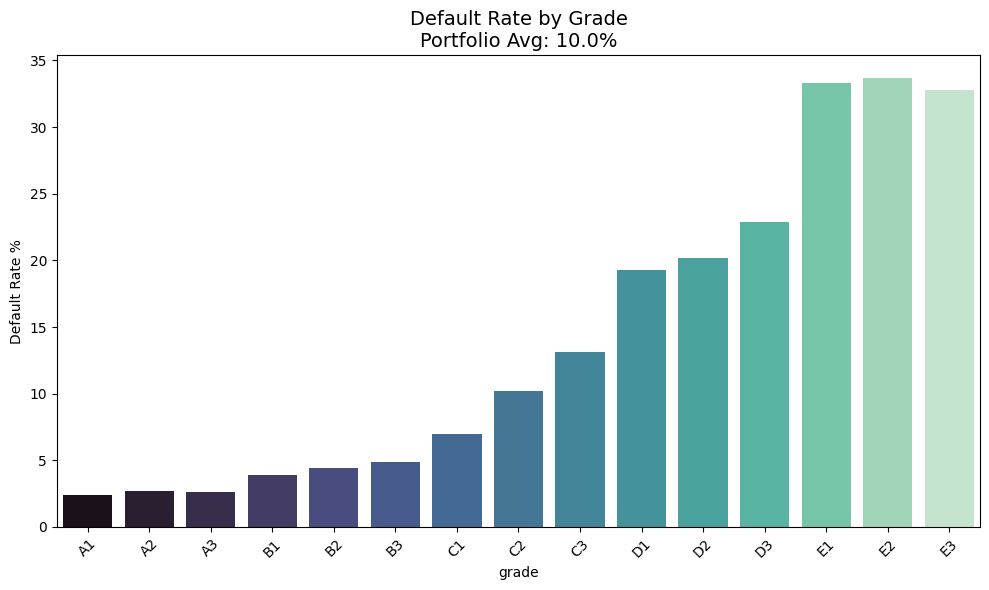

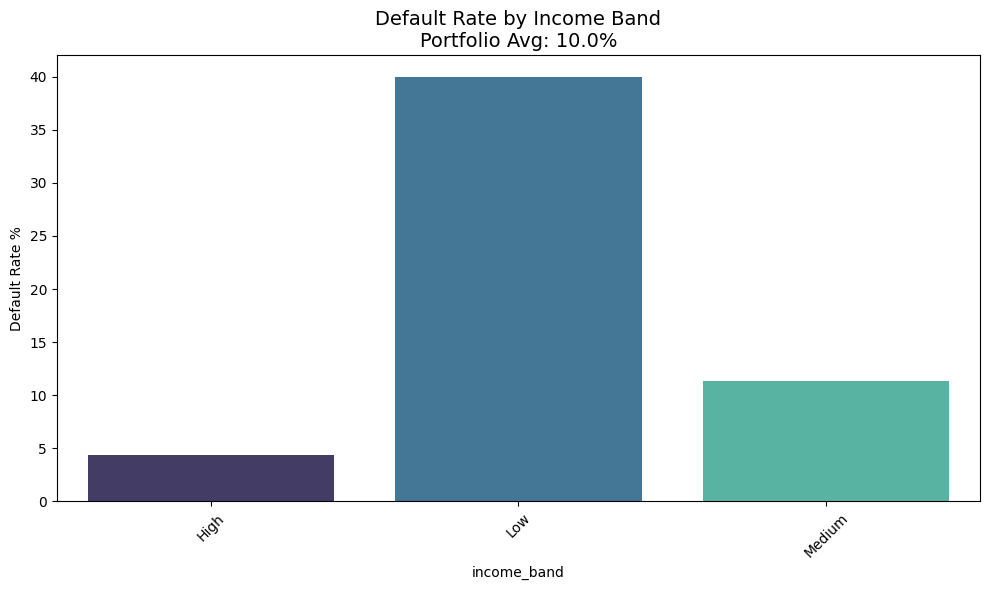

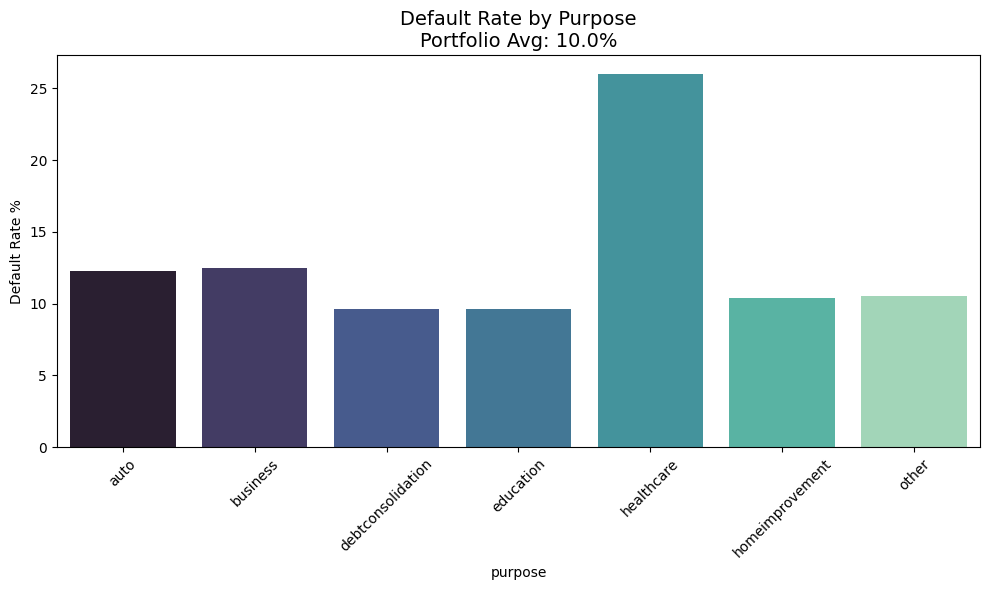

In [8]:
# Default rate by key segments
def plot_default_rates(df, col, title):
    rates = df.groupby(col)['default_flag'].agg(['count', 'sum', 'mean']).round(3)
    rates.columns = ['loans', 'defaults', 'default_rate']
    rates['default_rate_pct'] = rates['default_rate'] * 100
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=rates.reset_index(), x=col, y='default_rate_pct', hue=col, palette='mako')
    plt.title(f'{title}\nPortfolio Avg: {df["default_flag"].mean()*100:.1f}%', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Default Rate %')
    plt.tight_layout()
    plt.show()
    return rates

# Plot key drivers
print("🔥 DEFAULT RATE BY SEGMENT")
print("-" * 50)

grade_rates = plot_default_rates(df, 'grade', 'Default Rate by Grade')
income_rates = plot_default_rates(df, 'income_band', 'Default Rate by Income Band')
purpose_rates = plot_default_rates(df, 'purpose', 'Default Rate by Purpose')

📊 INTEREST RATE vs DEFAULT RISK
                    loans  default_rate_pct   exposure  avg_rate
interest_rate_band                                              
High (>=12%)        35439              16.3  736277411    15.191
Low (<8%)           24579               5.6  505789272     6.515
Medium (8-12%)      37922               7.0  780955453     9.928


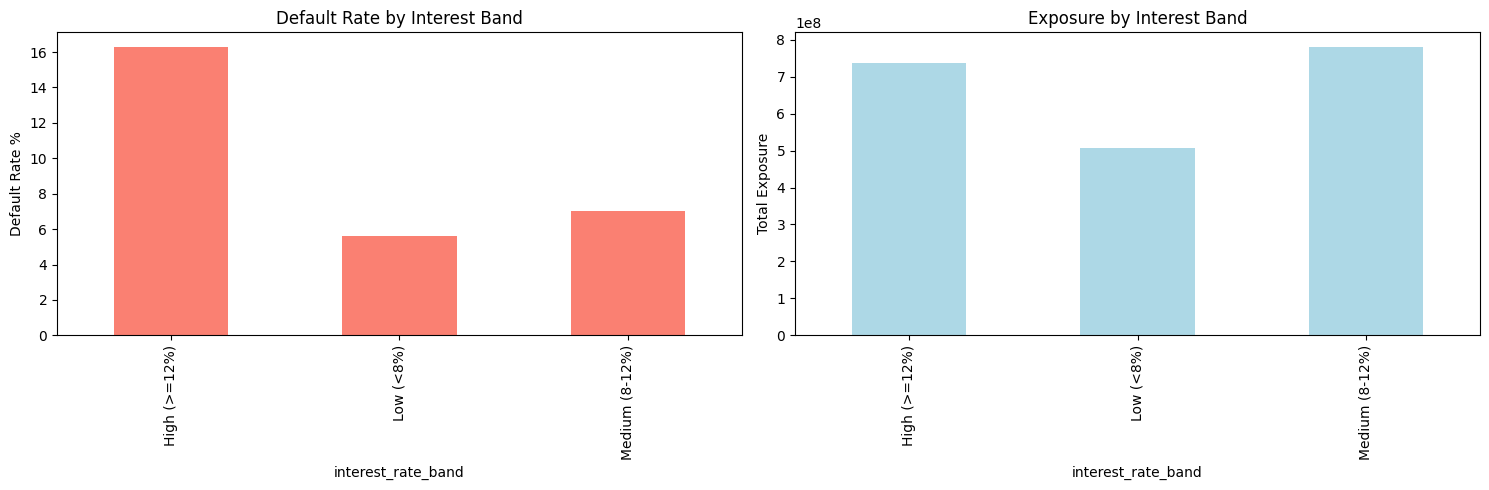

In [9]:
# Interest rate bands vs default
rate_analysis = df.groupby('interest_rate_band').agg({
    'default_flag': ['count', 'sum', 'mean'],
    'loan_amount': 'sum',
    'interest_rate': 'mean'
}).round(3)

rate_analysis.columns = ['loans', 'defaults', 'default_rate', 'exposure', 'avg_rate']
rate_analysis['default_rate_pct'] = rate_analysis['default_rate'] * 100

print("📊 INTEREST RATE vs DEFAULT RISK")
print(rate_analysis[['loans', 'default_rate_pct', 'exposure', 'avg_rate']])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Default rate
rate_analysis['default_rate_pct'].plot(kind='bar', ax=ax[0], color='salmon')
ax[0].set_title('Default Rate by Interest Band')
ax[0].set_ylabel('Default Rate %')

# Exposure
rate_analysis['exposure'].plot(kind='bar', ax=ax[1], color='lightblue')
ax[1].set_title('Exposure by Interest Band')
ax[1].set_ylabel('Total Exposure')

plt.tight_layout()
plt.show()


### 4. CORRELATION HEATMAP (Risk Drivers)

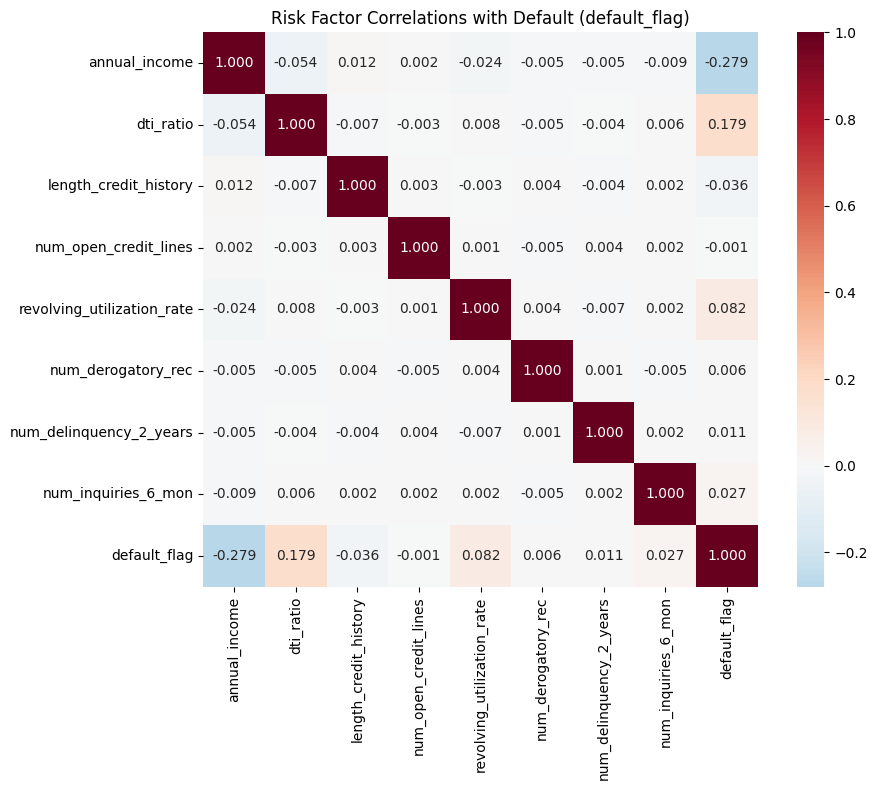

🔍 STRONGEST CORRELATIONS WITH DEFAULT:
dti_ratio                     0.178866
revolving_utilization_rate    0.081806
num_inquiries_6_mon           0.027479
num_delinquency_2_years       0.010556
num_derogatory_rec            0.005552
Name: default_flag, dtype: float64


In [10]:
# Select numeric risk features
risk_features = [
    'annual_income', 'dti_ratio', 'length_credit_history',
    'num_open_credit_lines', 'revolving_utilization_rate',
    'num_derogatory_rec', 'num_delinquency_2_years',
    'num_inquiries_6_mon', 'default_flag'
]

corr_matrix = df[risk_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f')
plt.title('Risk Factor Correlations with Default (default_flag)')
plt.tight_layout()
plt.show()

# Strongest correlations
print("🔍 STRONGEST CORRELATIONS WITH DEFAULT:")
correlations = corr_matrix['default_flag'].sort_values(ascending=False)
print(correlations[1:6])  # Top 5 excluding self